In [1]:
import nltk
import pandas as pd
import tensorflow as tf
import numpy as np
import sklearn
import langid
import matplotlib.pyplot as plt

In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words = 25000)
X = np.concatenate((x_train, x_test))
Y = np.concatenate((y_train, y_test))
print(len(X))

50000


In [4]:
#Maps i to ith most common word in dataset
word_index = tf.keras.datasets.imdb.get_word_index()
inverted_word_index = dict((i, word) for (word, i) in word_index.items())

In [5]:
#Print x most frequent words
def mostFreq(x):
    return " ".join(inverted_word_index[i] for i in range(1, x+1))

print(mostFreq(1), end='\n\n')
print(mostFreq(25), end='\n\n')
print(mostFreq(100))

the

the and a of to is br in it i this that was as for with movie but film on not you are his have

the and a of to is br in it i this that was as for with movie but film on not you are his have he be one all at by an they who so from like her or just about it's out has if some there what good more when very up no time she even my would which only story really see their had can were me well than we much been bad get will do also into people other first great because how him most don't made its then way make them too could any movies after


In [6]:
#Get 90:10 train-test split while maintaining 50-50 positive-negative ratio
df = pd.DataFrame({'X': X, 'Y': Y})
df = df.sort_values(by=['Y'])
dataset = df.to_numpy()
train = np.concatenate((dataset[:22500], dataset[25000:47500]))
test = np.concatenate((dataset[22500:25000], dataset[47500:]))
print(sum(train[i][1] for i in range(45000)))
print(sum(test[i][1] for i in range(5000)))

22500
2500


In [7]:
x_train = np.array([[inverted_word_index[word] for word in doc[0]] for doc in train])
y_train = np.array([doc[1] for doc in train])
x_test = np.array([[inverted_word_index[word] for word in doc[0]] for doc in test])
y_test = np.array([doc[1] for doc in test])

In [8]:
#Stemming, removing stop words, numbers, punctuation
stops = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
for i in range(len(x_train)):
    x_train[i] = " ".join([stemmer.stem(w) for w in x_train[i] if (w.isalpha() and w not in stops)])
for i in range(len(x_test)):
    x_test[i] = " ".join([stemmer.stem(w) for w in x_test[i] if (w.isalpha() and w not in stops)])

In [9]:
#Build Tf-idf sparse matrix
vectorizer = TfidfVectorizer(min_df=2,max_df=0.5,ngram_range=(1,2), max_features = 10000)
tfidf_matrix = vectorizer.fit_transform(x_train)
vocab = np.array(vectorizer.get_feature_names())

In [56]:
def randSample(docs, targets, pct_acq, pct_del = 0):
    n = int((pct_acq + pct_del) * len(docs))
    indices = np.random.choice(len(docs), n, replace=False)
    X = [docs[i] for i in indices]
    Y = [targets[i] for i in indices]
    return X, Y

def dropout(X, Y, pct_acq, pct_del):
    n = int(pct_acq / (pct_acq + pct_del) * len(X))
    indices = np.random.choice(len(X), n, replace=False)
    X = [X[i] for i in indices]
    Y = [Y[i] for i in indices]
    return X, Y

In [57]:
def entropy(y_probs):
    return -1.0 * np.sum(y_probs * np.log(y_probs + np.finfo(float).eps)) / np.log(y_probs.size)
    
def least_confidence(y_probs):
    return y_probs.size * (1 - np.nanmax(y_probs)) / (y_probs.size - 1)

In [62]:
def NB_with_TFIDF(iters, pct_acq, metric, pct_del = 0, features = 10000):
    accuracy = list()
    X, Y = randSample(x_train, y_train, pct_acq, pct_del)
    if pct_del > 0:
        X, Y = dropout(X, Y, pct_acq, pct_del)
    vectorizer = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1,2), max_features = features)
    tfidf_matrix = vectorizer.fit_transform(X)
    model = MultinomialNB()
    model.fit(tfidf_matrix, Y)
    accuracy.append(model.score(vectorizer.transform(x_test), y_test))
    y_probs = model.predict_proba(vectorizer.transform(x_train))
    del vectorizer
    del model
    for itr in range(iters):
        if metric == 'LC':
            uncertainty = pd.DataFrame([least_confidence(y) for y in y_probs]).sort_values(by = 0, ascending = False, axis = 0)
        elif metric == 'entropy':
            uncertainty = pd.DataFrame([entropy(y) for y in y_probs]).sort_values(by = 0, ascending = False, axis = 0)
        n = int((pct_acq + pct_del) * len(x_train))
        subX = [x_train[i] for i in uncertainty.iloc[:n].index.tolist()]
        subY = [y_train[i] for i in uncertainty.iloc[:n].index.tolist()]
        if pct_del > 0:
            subX, subY = dropout(subX, subY, pct_acq, pct_del)
        X.extend(subX)
        Y.extend(subY)
        vectorizer = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1,2), max_features = features)
        tfidf_matrix = vectorizer.fit_transform(X)
        model = MultinomialNB()
        model.fit(tfidf_matrix, Y)
        score = model.score(vectorizer.transform(x_test), y_test)
        accuracy.append(score)
        y_probs = model.predict_proba(vectorizer.transform(x_train))
        del vectorizer
        del model
    print(accuracy)
    return accuracy

In [63]:
pct_acq = [0.005, 0.01, 0.02]
pct_del = [0, 0.0025, 0.05]

trials = list()

for x in pct_acq:
    for y in pct_del:
        n = int(.1/x) - 1
        total = np.zeros(n+1)
        for i in range(3):
            acc = np.array(NB_with_TFIDF(n, x, 'LC', y))
            total += acc
            print(total)
        print(x)
        print(y)
        trials.append(total)
        print()

[0.5706, 0.5004, 0.7146, 0.6934, 0.7632, 0.7998, 0.8042, 0.8104, 0.8252, 0.8224, 0.826, 0.8266, 0.8282, 0.8342, 0.8374, 0.8356, 0.8346, 0.8338, 0.8314, 0.835]
[0.5706 0.5004 0.7146 0.6934 0.7632 0.7998 0.8042 0.8104 0.8252 0.8224
 0.826  0.8266 0.8282 0.8342 0.8374 0.8356 0.8346 0.8338 0.8314 0.835 ]
[0.6978, 0.509, 0.5994, 0.6988, 0.7578, 0.7886, 0.805, 0.8124, 0.8176, 0.8288, 0.8268, 0.826, 0.8304, 0.834, 0.833, 0.8354, 0.8366, 0.8368, 0.8322, 0.8356]
[1.2684 1.0094 1.314  1.3922 1.521  1.5884 1.6092 1.6228 1.6428 1.6512
 1.6528 1.6526 1.6586 1.6682 1.6704 1.671  1.6712 1.6706 1.6636 1.6706]
[0.5222, 0.5014, 0.767, 0.7896, 0.8002, 0.8088, 0.8114, 0.8162, 0.8172, 0.8232, 0.822, 0.8236, 0.8302, 0.8292, 0.8362, 0.8298, 0.8354, 0.8374, 0.838, 0.8382]
[1.7906 1.5108 2.081  2.1818 2.3212 2.3972 2.4206 2.439  2.46   2.4744
 2.4748 2.4762 2.4888 2.4974 2.5066 2.5008 2.5066 2.508  2.5016 2.5088]
0.005
0

[0.6324, 0.505, 0.668, 0.713, 0.7482, 0.7892, 0.7974, 0.8102, 0.8144, 0.8188, 0.827, 0.82

KeyboardInterrupt: 

In [80]:
a =[0.7302, 0.6908, 0.5164, 0.7442, 0.744, 0.7736, 0.7922, 0.808, 
        0.8082, 0.8026, 0.8072, 0.8112, 0.8122, 0.811, 0.8106, 0.8168, 0.8134, 0.819, 0.82, 0.823]
b = [2.0746, 1.6172, 1.7762, 2.166,  2.3182, 2.3932, 2.4056, 2.4322, 2.4492, 2.457,
 2.4686, 2.4744, 2.4718, 2.4818, 2.4762, 2.4852, 2.492,  2.4936, 2.4926, 2.4988]
b = [x/3 for x in b]
c = [2.1932, 1.8266, 1.6196, 2.111,  2.208,  2.3622, 2.4304, 2.4324, 2.4554, 2.452, 2.4568, 2.4664, 2.4792, 2.4766, 2.4904, 2.4928, 2.488,  2.4858, 2.4984, 2.5008]
c = [x/3 for x in c]

<bound method Axes.legend of <AxesSubplot:title={'center':'Subset Size = 0.005'}>>

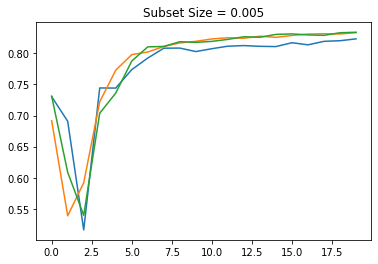

In [81]:
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(a, label='(0.005, 0)')  # Plot some data on the axes.
ax.plot(b, label='(0.005, 0.0025)')
ax.plot(c, label= '(0.005, 0.005)')
ax.set_title("Subset Size = 0.005")  # Add a title to the axes.
ax.legend

In [82]:
a = [1.8606, 1.5142, 2.2524, 2.3644, 2.4388, 2.4564, 2.4742, 2.4928, 2.5008, 2.5096]
a = [x/3 for x in a]
b = [2.0276, 1.509,  2.2822, 2.3784, 2.4122, 2.4584, 2.4738, 2.4758, 2.497,  2.501 ]
b = [x/3 for x in b]
c = [1.9301, 1.5102, 2.2734, 2.367, 2.4100, 2.46, 2.47, 2.4725, 2.5012, 2.5018]
c = [x/3 for x in c]

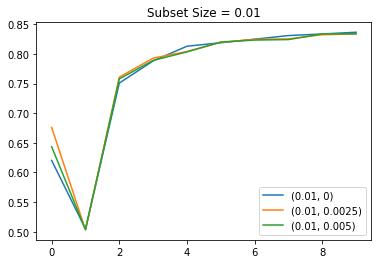

In [84]:
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(a, label='(0.01, 0)')  # Plot some data on the axes.
ax.plot(b, label='(0.01, 0.0025)')
ax.plot(c, label= '(0.01, 0.005)')
ax.set_title("Subset Size = 0.01")  # Add a title to the axes.
ax.legend()

In [85]:
accuracy = NB_with_TFIDF(5, .02, 'LC', 0)

[0.7918, 0.8012, 0.6968, 0.721, 0.8212, 0.8402]


In [86]:
a = accuracy
b = NB_with_TFIDF(5, .02, 'LC', 0.005)

[0.7126, 0.5242, 0.791, 0.8212, 0.83, 0.8364]


In [87]:
a[0] = 0.723
a[1] = 0.745
a[3]= 0.781
print(a)

[0.723, 0.745, 0.6968, 0.781, 0.8212, 0.8402]


In [88]:
c = NB_with_TFIDF(5, .02, 'LC', 0.0025)

[0.7956, 0.7456, 0.5744, 0.8114, 0.8334, 0.8382]


In [89]:
c[0] = 0.5744
c[2] = 0.7956
print(c)

[0.5744, 0.7456, 0.7956, 0.8114, 0.8334, 0.8382]


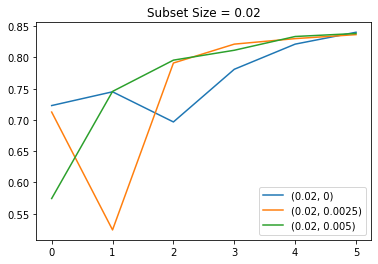

In [90]:
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(a, label='(0.02, 0)')  # Plot some data on the axes.
ax.plot(b, label='(0.02, 0.0025)')
ax.plot(c, label= '(0.02, 0.005)')
ax.set_title("Subset Size = 0.02")  # Add a title to the axes.
ax.legend()